## Figure: Agreement and Recource

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pandas as pd
import numpy as np
from functools import partial
import logging

from mono_multi.setup import (
    FIGURES_ROOT_DIR,
)
from mono_multi.metrics import (
    matrix_pairwise_evals,
)
from mono_multi.utils import (
    load_model_outputs_same_prompt,
    get_size_and_it,
    load_results_overview,
    add_evals_to_df,
    load_data_if_needed,
    filter_results_all_tasks,
)

from mono_multi.plotting import (
    plot_recourse_wrapper,
    plot_agreement_wrapper,
    configure_legend,
)

In [ ]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "same-prompt"
TASKS = ["ACSIncome"]

In [4]:
select_by = "accuracy"  #
fit_threshold_for = "balanced_accuracy"  #'accuracy' #

## Load predictions ACSIncome

In [ ]:
num_shots = 0
threshold_fitted = True

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=True
)
df = df[df["task"].isin(TASKS)]
df = df[df["correct_order_bias"] == 0]
if threshold_fitted and ("threshold_obj" in df.columns):
    df = df[df["threshold_obj"] == fit_threshold_for]

df["predictions_path"] = "/Volumes/mgorecki/monoculture/" + df["predictions_path"]

df.shape

(50, 19)

In [6]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [7]:
predictions_all = load_model_outputs_same_prompt(
    df, tasks=TASKS, return_risk_scores=False
)

df = add_evals_to_df(df)

ACSIncome


## Restrict analysis to models based on performance or true labels?

In [8]:
try:
    data_all
except NameError:
    print("data not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

data not yet defined
ACSIncome


In [9]:
restrict_to_better_const = True
restrict_to_positive_label = True
restrict_to_negative_label = False
restrict_to_top_eps = True
eps = 0.05
restrict_to_topk = False
topk = 10

predictions, data = filter_results_all_tasks(
    predictions=predictions_all.copy(),
    df=df,
    data={t: val for t, val in data_all.items() if t in TASKS},
    tasks=TASKS,
    restrict_to_better_const=restrict_to_better_const,
    restrict_to_positive_label=restrict_to_positive_label,
    restrict_to_negative_label=restrict_to_negative_label,
    restrict_to_top_eps=restrict_to_top_eps,
    restrict_to_topk=restrict_to_topk,
    eps=eps,
    topk=topk,
    acc=select_by,
)

ACSIncome
- before: (166450, 50)
Using accuracy for comparison.
- after: (61233, 27)


## Plot

In [10]:
# helpers
def build_filename():
    parts = [
        f"agreement-recourse-{num_shots}-shot",
        f"-{TASKS[0]}",
        (
            f"_selected_by-{select_by.replace('_','-')}"
            f"_tresh_fitted-{fit_threshold_for.replace('_','-')}"
            if threshold_fitted
            else ""
        ),
        "_better_const" if restrict_to_better_const else "",
        "_pos_instances" if restrict_to_positive_label else "",
        "_neg_instances" if restrict_to_negative_label else "",
        f"_eps{str(eps).replace('.', '_')}" if restrict_to_top_eps else "",
        f"_top{topk}" if restrict_to_topk else "",
    ]
    return "".join(parts)

mean agreement: 0.8837
mean agreement at random: 0.6366
agreement-recourse-0-shot-ACSIncome_selected_by-accuracy_tresh_fitted-balanced-accuracy_better_const_pos_instances_eps0_05


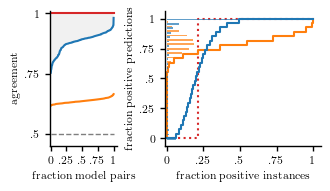

In [11]:
tasks_to_plot = TASKS
selection_by = "accuracy"

# fig_width = plt.rcParams["figure.figsize"][0]
# fig_height = 2 if num_shots == 0 else 1.5
fig_width = 0.58* plt.rcParams["figure.figsize"][0]  # * 2 * (2/6) * (8/5)
fig_height = 0.6 * plt.rcParams["figure.figsize"][1]  # 0.8*

fig, axs = plt.subplots(
    1,
    2,
    figsize=(fig_width, fig_height),
    constrained_layout=True,
    gridspec_kw={"width_ratios": [3/ 10, 7 / 10]}, #, "wspace": 0.075},
)

for i, task in enumerate(tasks_to_plot):
    # agreement
    mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))
    axs[0], agreement_data = plot_agreement_wrapper(
        axs[0], predictions=predictions[task], df = df[mask], xlabel="fraction model pairs"
    )
    print(f"mean agreement: {agreement_data['observed'].agreement.mean():.4f}")
    print(
        f"mean agreement at random: {agreement_data['baseline'].agreement.mean():.4f}"
    )

    # recourse
    axs[1], observed, at_random = plot_recourse_wrapper(
        axs[1],
        predictions=predictions[task],
        df=df[mask],
        bootstrap=False,
        ylabel="fraction positive predictions",
        xlabel="fraction positive instances"
    )
    # configure_legend(fig, axs, offset=0.24)
# fig.suptitle('ACSIncome')

file_name = build_filename()
for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig1_{file_name}{ending}")
print(file_name)

plt.show()

#### What is the maximum agreement models of different accuracy can achieve?

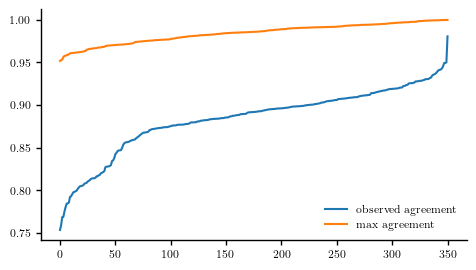

In [ ]:
from itertools import combinations_with_replacement
from mono_multi.analysis.metrics import get_observed_pairwise_agreement_rate
from mono_multi.analysis.plotting import build_agreement_curve


mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))
acc_df = df[mask][["model", 'accuracy']].set_index("model").T
accs = acc_df.values.squeeze()

idx_pairs = list(combinations_with_replacement(range(len(accs)), 2))
max_agree = [1- abs(accs[i] -  accs[j]) for i,j in idx_pairs if i!=j]

observed_agreement = build_agreement_curve(model_data=predictions[task], pairwise_fun=get_observed_pairwise_agreement_rate)
plt.plot(observed_agreement, label = 'observed agreement')
plt.plot(sorted(max_agree), label='max agreement')
plt.legend()


In [13]:
from monoculture.analysis.utils import apply_cumulative

# get CDF values
obs_cdf = apply_cumulative(observed[:, 0])
baseline_cdf = apply_cumulative(at_random[:, 0])

In [14]:
# fraction of individuals rejected by more than half
# observed (frac_individuals, frac_models) - sorted by model fraction
print(
    f"Observed: {obs_cdf[observed[:, 1] <= 0.5][-1].item()*100:.2f}% of individuals are accepted by at most {observed[observed[:, 1] <= 0.5][-1, 1]*100:.2f}% of the models."
)
print(
    f"Baseline: {baseline_cdf[at_random[:, 1] <= 0.5][-1].item()*100:.2f}% of individuals are accepted by at most {at_random[at_random[:, 1] <= 0.5][-1, 1]*100:.2f}% of the models."
)

Observed: 19.97% of individuals are accepted by at most 48.15% of the models.
Baseline: 0.05% of individuals are accepted by at most 48.15% of the models.


In [15]:
# check for lower 20% of individuals
print(
    f"Observed: {obs_cdf[obs_cdf <= 0.2][-1].item()*100:.2f}% of individuals are accepted by at most {observed[obs_cdf <= 0.2][-1, 1]*100:.2f}% of the models."
)
print(
    f"Baseline: {baseline_cdf[baseline_cdf <= 0.2][-1].item()*100:.2f}% of individuals are accepted by at most {at_random[baseline_cdf <= 0.2][-1, 1]*100:.2f}% of the models."
)

Observed: 19.97% of individuals are accepted by at most 48.15% of the models.
Baseline: 10.86% of individuals are accepted by at most 66.67% of the models.
